# **Title:** When Words and Images Speak, AI Listens "Multimodal Disaster Tweet Classification with VisualBert"


## **Dataset:** [CrisisMMD2INF on HuggingFace](https://huggingface.co/datasets/xiaoxl/crisismmd2inf) and [CrisisMMD2HUUM on HuggingFace](https://huggingface.co/datasets/xiaoxl/crisismmd2hum)  
This dataset includes social media posts (tweets) with both textual content and corresponding images, making it ideal for multimodal learning.

## **Objective:** Develop a model that classifies social media posts during disasters into categories such as 'informative' or 'uninformative' and assesses their urgency level. This involves multimodal (text + image) classification.

## **Approach:**  
- Use ResNet50/Resnet152/DINOv2 to extract image embeddings.  We experiment with these different visual embedding models and advise on which performs better.
- Tokenize and encode text using BERT tokenizer.  
- Combine both modalities using VisualBERT for multimodal classification.  
- Evaluate performance


---

# Project stages

This project consists of two stages of multimodal tweet classification using VisualBERT and ResNet-50:


##  Stage 1: Informativeness Classification  
**Dataset Used:** [CrisisMMD2INF](https://huggingface.co/datasets/xiaoxl/crisismmd2inf)  
This dataset includes social media posts annotated as *Informative* or *Not Informative*.

In this stage, we conducted experiments analyzing different visual embedding models.

- **Train set:** 9,601 samples  
- **Validation set:** 1,573 samples  
- **Test set:** 1,534 samples  

** Model Initialized with Pretrained Weights:**  
- **Text encoder:** BERT tokenizer  
- **Image encoder:** ResNet-50 / ResNet-152 / DINOv2
- **Fusion:** Text and visual embeddings fed into VisualBERT  
- **Loss:** Class-weighted CrossEntropyLoss  
- **Training Epochs:** 20


---

##  Stage 2: Humanitarian Content Classification  
**Dataset Used:** [CrisisMMD2HUM](https://huggingface.co/datasets/xiaoxl/crisismmd2hum)  
This dataset contains tweets labeled into more specific humanitarian categories.

In this stage we use the best-performing visual embedding model from stage one, which is the Resnet-152 CNN based model.

- **Train set:** 2,140 samples  
- **Validation set:** 473 samples  
- **Test set:** 955 samples  

** Model & Pipeline:**  
- Same multimodal VisualBERT + ResNet-152 architecture  
- Adjusted for 5 humanitarian classes  
- Applied weighted loss to address label imbalance  
- Training Epochs: 20

---


# Classification Report

We used `classification_report` from the `sklearn.metrics` module to evaluate the performance of our VisualBERT model on both the validation and test datasets.

The classification report provides key metrics for each class in the classification task:

- **Precision:** The ratio of correctly predicted positive observations to the total predicted positives. High precision means fewer false positives.
- **Recall:** The ratio of correctly predicted positive observations to all actual positives. High recall means fewer false negatives.
- **F1-Score:** The harmonic mean of precision and recall. It balances both metrics and is especially useful for imbalanced datasets.
- **Support:** The number of true instances of each class in the dataset.

In our case (Informative vs. Uninformative classification), the report gives insight into how well the model distinguishes between the two categories. The macro and weighted averages are also reported:
- **Macro Average:** Averages the metrics across classes without considering class imbalance.
- **Weighted Average:** Averages the metrics while taking into account the number of instances per class.

This report helps identify whether the model performs equally well on both classes or favors one over the other.

---

# References and Resources

**VisualBERT Paper:** Liunian Harold Li et al., VisualBERT: A Simple and Performant Baseline for Vision and Language, arXiv:1908.03557.​

**Hugging Face VisualBERT Documentation:** https://huggingface.co/docs/transformers/model_doc/visual_bert​

**Pre-trained VisualBERT Model:** https://huggingface.co/uclanlp/visualbert-vqa-coco-pre​

**CrisisMMD2 Dataset:** https://huggingface.co/datasets/xiaoxl/crisismmd2inf​


---

# Stage 1: Informativeness Classification (crisismmd2inf)

In the first stage of the pipeline, we determine whether each disaster-related tweet is **Informative** or **Not Informative**. This classification step is essential for filtering out irrelevant content and prioritizing messages that convey actionable information.

We use the `xiaoxl/crisismmd2inf` dataset from Hugging Face, which includes tweets paired with associated images and annotated labels for informativeness.

The possible classes are:
- **Informative**: The tweet contains useful or relevant crisis-related information.
- **Not Informative**: The tweet does not contain helpful content for disaster response.

This task uses a **multimodal classification approach**, combining textual and visual features through a shared model architecture (VisualBERT + ResNet), similar to Stage 2.


## Setup

### Install needed packages

In [ ]:
!pip install -U datasets

In [ ]:
# Install Required Libraries
!pip install torch torchvision transformers scikit-learn pillow

### Import needed packages

In [3]:
import torch
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F

from transformers import VisualBertModel, BertTokenizerFast
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datasets import load_dataset
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet152, ResNet152_Weights


###  Environment Configuration

This section outlines the hyperparameters and system setup used for fine-tuning the VisualBERT model on the CrisisMMD2INF dataset.


**Text Tokenization:**
- `MODEL_NAME = 'bert-base-uncased'`  
  A pre-trained BERT tokenizer from Hugging Face is used to convert tweet text into token IDs. The lowercase (uncased) version is suitable for most general English NLP tasks.

**Sequence Length:**
- `MAX_SEQ_LENGTH = 128`  
  Sets the maximum number of tokens per tweet input to 128 to standardize input size and control memory usage.

**VisualBERT Configuration:**
- `DROPOUT = 0.3`  
  Applies a 30% dropout in the classification layer to prevent overfitting during fine-tuning.

**Data Loading Settings:**
- `BATCH_SIZE = 64` — Number of samples per batch during training  
- `WORKERS = 4` — Number of subprocesses used to load data in parallel  
- `SHUFFLE = True` — Shuffles the dataset each epoch to ensure robustness  
- `PIN_MEMORY = True` — Speeds up GPU training by enabling fast memory transfer


**Optimization Settings:**
- `LEARNING_RATE = 1e-5` — A small learning rate suitable for fine-tuning pretrained models  
- `WEIGHT_DECAY = 1e-4` — L2 regularization to prevent overfitting

**Learning Rate Scheduler:**
- `PATIENCE = 2` — Reduces the learning rate if validation loss doesn’t improve for 2 epochs  
- `FACTOR = 0.5` — Reduces learning rate by a factor of 0.5 when triggered

**Training Loop:**
- `EPOCHS = 20` — Number of complete passes over the training set

In [4]:
# Tokenizer
MODEL_NAME = 'bert-base-uncased'

#CrisisCustom Model
MAX_SEQ_LENGTH = 128

# Training Configuration for VisualBERT
DROPOUT = 0.3

# Training Configuration for the NN
# Loading the DataLoader
BATCH_SIZE = 64
WORKERS = 4
SHUFFLE=True
PIN_MEMORY=True
# Loss and Optimizer
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
# Scheduler
PATIENCE = 2
FACTOR = 0.5
# Training of the Model
EPOCHS = 10

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


##  Dataset Prep

In this step, we prepare the **CrisisMMD2INF** dataset for training and evaluation.

####  Loading the Dataset
We use Hugging Face’s `load_dataset` function to load the full CrisisMMD2INF dataset, which includes:
- Textual tweet content
- Associated disaster-related images
- Multiple labels (e.g., informativeness, urgency, type)

#### Dataset Splits
The dataset is already split into three parts:
- **Train:** Used for model training
- **Validation (dev):** Used to monitor performance and tune hyperparameters
- **Test:** Used for final evaluation after training

```python
{
  "train_size": 9601,
  "validation_size": 1573,
  "test_size": 1534
}


In [ ]:
# Load the full dataset from Hugging Face
dataset = load_dataset("xiaoxl/crisismmd2inf")

# Split the dataset
train_dataset = dataset["train"]
val_dataset = dataset["dev"]
test_dataset = dataset["test"]

# Count and print the sizes
print({
    "train_size": len(train_dataset),
    "validation_size": len(val_dataset),
    "test_size": len(test_dataset)
})

# Count function
# def count_labels(data_split):
#     label_counts = {"informative": 0, "not_informative": 0}
#     for example in data_split:
#         label = example["label"]  # This is a string: 'informative' or 'not_informative'
#         if label in label_counts:
#             label_counts[label] += 1
#     return label_counts

# print("Train:", count_labels(dataset["train"]))
# print("Validation:", count_labels(dataset["dev"]))
# print("Test:", count_labels(dataset["test"]))

In [6]:
# Label mapping
label2id = {'informative': 1, 'not_informative': 0}

###  Image Transformations for Data Augmentation

This cell defines a set of image transformations using `torchvision.transforms.Compose`, which is applied to the training images to augment the dataset.

- **RandomResizedCrop(224)**: Randomly crops the image to 224×224 pixels, scaling the crop between 80% and 100% of the original size.
- **RandomHorizontalFlip()**: Randomly flips the image horizontally with a probability of 0.5.
- **RandomRotation(10)**: Rotates the image randomly within ±10 degrees.
- **ColorJitter**: Randomly changes the brightness, contrast, and saturation to simulate lighting variations.
- **GaussianBlur(3)**: Applies Gaussian blur with a kernel size of 3 to smooth the image slightly.
- **ToTensor()**: Converts the image to a PyTorch tensor and scales pixel values to [0, 1].
- **Normalize(mean, std)**: Normalizes the image using the standard mean and standard deviation values of the ImageNet dataset.


In [7]:
# Image transform
image_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

## Tokenizer and ResNet Feature Extractor Setup

This cell sets up two essential components of the multimodal model: the tokenizer for text and the Visual embedding model for image feature extraction.

- **BERT Tokenizer Initialization**:
  - Loads a pre-trained BERT tokenizer using `BertTokenizerFast.from_pretrained(MODEL_NAME)`.
  - The tokenizer uses the vocabulary of a lowercase (uncased) BERT model, which is well-suited for informal language such as tweets.

- **ResNet50 Image Encoder**:
  - Loads a pre-trained `ResNet50` model with `IMAGENET1K_V1` weights.
  - Loads a pre-trained `ResNet152` model with `IMAGENET1K_V1` weights.
  - The fully connected (classification) layer is replaced with `nn.Identity()` to use ResNet purely as a feature extractor.

- **Freezing and Fine-Tuning Layers**:
  - All layers in ResNet are frozen (no gradient updates during training).
  - The last 20 layers are optionally unfrozen to allow fine-tuning of deeper features, striking a balance between efficiency and model adaptability.

In [ ]:
# Load tokenizer and pretrained ResNet model
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

In [28]:
# VisualBERT is based on BERT, so we tokenize tweets using the same vocabulary. The uncased version is robust to informal Twitter language (e.g., capital letters, hashtags).
#updated deprecated code here
resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet50.fc = nn.Identity()
resnet50 = resnet50.to(device)
resnet50.eval()

# Freeze all layers in ResNet
for param in resnet50.parameters():
    param.requires_grad = False

for param in list(resnet50.parameters())[-20:]:
    param.requires_grad = True



resnet152 = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
resnet152.fc = nn.Identity()
resnet152 = resnet152.to(device)
resnet152.eval()


# Freeze all layers in ResNet
for param in resnet152.parameters():
    param.requires_grad = False

for param in list(resnet152.parameters())[-20:]:
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]


## DINOv2 feature extractor setup

**DINOv2 Vision Transformer**:
- Uses `facebook/dinov2-base`, a self-supervised vision transformer from Meta AI.
- Outputs high-quality semantic features that align well with transformer-based multimodal models like VisualBERT.

- All layers in are frozen (no gradient updates during training).
- The last 20 layers are optionally unfrozen to allow fine-tuning of deeper features, striking a balance between efficiency and model adaptability.

- A linear projection layer is added to generate 2048 sized embedings


### install needed packages

In [ ]:
!pip install timm

In [45]:
from transformers import AutoModel, AutoImageProcessor
import torch

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
dinov2 = AutoModel.from_pretrained("facebook/dinov2-base")

dinov2.eval()
dinov2.to(device)

# Freeze all parameters of DINOv2
for param in dinov2.parameters():
    param.requires_grad = False
# Optionally unfreeze the last few layers (fine-tuning)
for param in list(dinov2.parameters())[-20:]:
    param.requires_grad = True

### Projecting DINOv2 Embeddings to VisualBERT Format
DINOv2 outputs a 768-dimensional pooled feature vector. To match VisualBERT's visual_embeds format (typically 2048-dimensional), a projection layer is added.

In [46]:
class ProjectedDINO(nn.Module):
    def __init__(self, dinov2):
        super().__init__()
        self.dinov2 = dinov2
        self.proj = nn.Linear(768, 2048)  # match VisualBERT visual_embeds

    def forward(self, pixel_values):  # Accept keyword 'pixel_values'
        with torch.no_grad():
            features = self.dinov2(pixel_values=pixel_values).pooler_output
        return self.proj(features)


In [47]:
projected_dinov2 = ProjectedDINO(dinov2).to(device)


##  Custom Dataset Class: `CrisisDataset`

This cell defines a custom PyTorch `Dataset` class tailored for multimodal crisis data, combining both text and image features.




In [52]:
# Custom dataset class to return tokenized text, processed image, and label for each data sample.
class CrisisDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, transform):
        self.data = hf_dataset
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        text = example['tweet_text']
        label = label2id[example['label']]
        encoded = self.tokenizer(text, padding='max_length', truncation=True, max_length=MAX_SEQ_LENGTH, return_tensors='pt')
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)
        image_path = example['image']

        try:
            image = Image.open(image_path).convert('RGB')  # now image_path is defined
            image = self.transform(image)
        except:
            image = torch.zeros((3, 224, 224))

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label)
        }

## VisualBERT-Based Multimodal Classifier

This cell defines a custom PyTorch neural network called `VisualBERTClassifier`, which uses the `VisualBertModel` to combine both text and image features for classification.

#### Initialization (`__init__`)
- **VisualBERT Backbone**:
  - Loads a pre-trained VisualBERT model (`uclanlp/visualbert-vqa-coco-pre`), which is originally trained on Visual Question Answering (VQA) data.
  - All layers are frozen to prevent them from updating during training.
  - The last two encoder layers are selectively unfrozen to allow limited fine-tuning and improve task-specific adaptation.

- **Model Architecture**:
  - `hidden_size`: Size of the pooled output from VisualBERT (typically 768).
  - A fully connected layer (`fc1`) reduces dimensionality to an intermediate size (e.g., 512).
  - `LayerNorm` normalizes the intermediate features to stabilize training.
  - Dropout layers are added before and after the dense layers to prevent overfitting.
  - The final layer (`fc2`) outputs logits for binary classification (2 classes).

#### Forward Pass (`forward`)
- Takes in:
  - `input_ids` and `attention_mask` for the textual input.
  - `visual_embeds` containing image features extracted by ResNet.
- Feeds inputs through the VisualBERT model and extracts the pooled output.
- Applies dropout, dense transformation, activation (ReLU), normalization, and a final linear layer to produce the logits.

This model forms the core of the multimodal classification system, integrating text and vision in a unified architecture.


In [15]:
# VisualBERT-based classifier
class VisualBERTClassifier(nn.Module):
    def __init__(self):
        super(VisualBERTClassifier, self).__init__()
        self.bert = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

        # Freeze all layers of VisualBERT
        for param in self.bert.parameters():
            param.requires_grad = False

        # Optionally unfreeze just the last 2 encoder layers
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True

        # Dimensions
        hidden_size = self.bert.config.hidden_size  # Example: 768
        intermediate_size = 512  # You can even try 256 later for faster training

        # Layers
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.norm = nn.LayerNorm(intermediate_size)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(intermediate_size, 2)

    def forward(self, input_ids, attention_mask, visual_embeds):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            visual_embeds=visual_embeds
        )
        pooled = outputs.pooler_output

        x = self.dropout1(pooled)
        x = F.relu(self.fc1(x))
        x = self.norm(x)
        x = self.dropout2(x)
        logits = self.fc2(x)

        return logits

In [16]:
class VisualBERTClassifier_DINOv2(nn.Module):
    def __init__(self):
        super(VisualBERTClassifier_DINOv2, self).__init__()
        self.bert = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

        # Freeze all layers of VisualBERT
        for param in self.bert.parameters():
            param.requires_grad = False

        # Optionally unfreeze just the last 2 encoder layers
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True

        hidden_size = self.bert.config.hidden_size
        intermediate_size = 512

        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.norm = nn.LayerNorm(intermediate_size)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(intermediate_size, 2)

    def forward(self, input_ids, attention_mask, visual_embeds, visual_attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            visual_embeds=visual_embeds,
            visual_attention_mask=visual_attention_mask,  # <- pass this!
        )
        pooled = outputs.pooler_output

        x = self.dropout1(pooled)
        x = F.relu(self.fc1(x))
        x = self.norm(x)
        x = self.dropout2(x)
        logits = self.fc2(x)

        return logits


## Model Initialization, Class Weights, Dataloaders, and Optimizer Setup

These cells prepares the core training components of the multimodal classifier:



In [36]:
# Initialize model
model_50 = VisualBERTClassifier().to(device)
model_152 = VisualBERTClassifier().to(device)


In [44]:
model_Dino_v2 = VisualBERTClassifier_DINOv2().to(device)

In [18]:
# Weighted CrossEntropyLoss to address class imbalance
import torch.nn as nn

# Class counts from training data
train_counts = {'informative': 6345, 'not_informative': 3256}
total = train_counts['informative'] + train_counts['not_informative']

# Compute class weights (inverse frequency)
weight_uninformative = total / (2 * train_counts['not_informative'])
weight_informative = total / (2 * train_counts['informative'])

class_weights = torch.tensor([weight_uninformative, weight_informative], dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)


In [38]:
# Load datasets
train_data = CrisisDataset(train_dataset, tokenizer, image_transform)
val_data = CrisisDataset(val_dataset, tokenizer, image_transform)
test_data = CrisisDataset(test_dataset, tokenizer, image_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=WORKERS, pin_memory=PIN_MEMORY)

# Loss and optimizer
optimizer_50 = torch.optim.AdamW(model_50.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_50 = ReduceLROnPlateau(optimizer_50, mode='min', patience=PATIENCE, factor=FACTOR, verbose=True)



# Loss and optimizer
optimizer_152 = torch.optim.AdamW(model_152.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_152 = ReduceLROnPlateau(optimizer_152, mode='min', patience=PATIENCE, factor=FACTOR, verbose=True)

In [49]:
# Loss and optimizer
optimizer_DINOv2 = torch.optim.AdamW(model_Dino_v2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_DINOv2 = ReduceLROnPlateau(optimizer_DINOv2, mode='min', patience=PATIENCE, factor=FACTOR, verbose=True)

## Training Function with Mixed Precision and Validation

This cell defines the `train_model` function to train the `VisualBERTClassifier` using a ResNet image encoder, leveraging **mixed precision training** for improved efficiency on GPUs.

#### Mixed Precision Setup
- Uses `torch.amp.autocast` and `GradScaler` for automatic mixed precision (AMP) training, which:
  - Reduces memory usage.
  - Speeds up training on supported hardware (like NVIDIA GPUs).
- `GradScaler` helps prevent underflow when using lower-precision floats by scaling gradients dynamically.

#### Training Loop
- For each epoch:
  - Iterates through batches from the `train_loader`.
  - Sends inputs (text, images, labels) to the device.
  - **Image features** are extracted using the frozen ResNet model (`visual_embeds = resnet(images)`), with gradients disabled.
  - Visual features are unsqueezed to fit the expected shape for `VisualBERT`.
  - **Forward pass** is done under `autocast` context for mixed precision.
  - **Loss** is computed using a class-weighted cross-entropy loss.
  - **Backpropagation** uses `scaler.scale(loss).backward()` to handle precision safely.
  - Optimizer and scaler are updated per batch.
  - Tracks cumulative training loss and accuracy.

#### Validation Phase
- After each epoch, the model switches to evaluation mode with `model.eval()`.
- Computes validation loss and accuracy without gradient tracking.
- Uses the same image-text processing pipeline as training.
- Metrics are stored in the `history` dictionary.

#### Output
- After each epoch, prints training and validation loss/accuracy.
- Returns a `history` dictionary containing:
  - `train_loss`, `train_acc`, `val_loss`, `val_acc` for plotting and analysis.

This modular and efficient function supports training multimodal models with large datasets, handling both performance and stability.


In [31]:

from torch.amp import autocast, GradScaler

scaler = torch.amp.GradScaler('cuda')

def train_model(model, resnet, train_loader, val_loader, optimizer, loss_fn, device, epochs):
    model.to(device)
    resnet.to(device)
    model.train()

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                visual_embeds = resnet(images)
            visual_embeds = visual_embeds.unsqueeze(1)

            with autocast("cuda"):
                logits = model(input_ids=input_ids, attention_mask=attention_mask, visual_embeds=visual_embeds)
                loss = loss_fn(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                visual_embeds = resnet(images)
                visual_embeds = visual_embeds.unsqueeze(1)

                with autocast("cuda"):
                    logits = model(input_ids=input_ids, attention_mask=attention_mask, visual_embeds=visual_embeds)
                    loss = loss_fn(logits, labels)

                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total

        model.train()

        history['train_loss'].append(avg_loss)
        history['train_acc'].append(accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.2f} | Val Loss: {avg_val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}")

    return history


In [22]:
from torch.amp import autocast, GradScaler

scaler = torch.amp.GradScaler('cuda')

def extract_visual_embeddings(images):
    with torch.no_grad():
        inputs = processor(images=images, return_tensors="pt").to(device)
        projected = projected_dinov2(**inputs)  # This is already the final visual embed
        return projected.unsqueeze(1)  # shape (B, 1, hidden_dim)


def train_model_DINOv2(model, train_loader, val_loader, optimizer, loss_fn, device, epochs):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            visual_embeds = extract_visual_embeddings(images)
            visual_attention_mask = torch.ones(visual_embeds.size()[:-1], dtype=torch.long).to(device)  # (B, 1)

            # Remove autocast here

            with autocast("cuda"):
                logits = model(input_ids=input_ids,
                               attention_mask=attention_mask,
                               visual_embeds=visual_embeds,
                               visual_attention_mask=visual_attention_mask,)
                loss = loss_fn(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                visual_embeds = extract_visual_embeddings(images)
                visual_attention_mask = torch.ones(visual_embeds.size()[:-1], dtype=torch.long).to(device)


                with autocast("cuda"):
                    logits = model(input_ids=input_ids, attention_mask=attention_mask, visual_embeds=visual_embeds, visual_attention_mask=visual_attention_mask,)
                    loss = loss_fn(logits, labels)

                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total

        scheduler.step(avg_val_loss)

        history['train_loss'].append(avg_loss)
        history['train_acc'].append(accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.2f} | Val Loss: {avg_val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}")

    return history


## Evaluation Setup


### Evaluation Functions: `evaluate_model` and `evaluate_model_DINOv2`

These reusable functions evaluates the model on any dataset split (validation or test) and prints a detailed classification report.

In [24]:
from sklearn.metrics import classification_report

def evaluate_model(model, resnet, dataloader, device, loss_fn, split_name="Validation"):
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            visual_embeds = resnet(images).unsqueeze(1)
            logits = model(input_ids=input_ids, attention_mask=attention_mask, visual_embeds=visual_embeds)

            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    val_loss /= len(dataloader)
    print(f"\n{split_name} Loss: {val_loss:.4f}")
    print(f"{split_name} Report:\n", classification_report(all_labels, all_preds, zero_division=0, target_names=['Uninformative', 'Informative']))
    return val_loss


In [25]:
from sklearn.metrics import classification_report

def evaluate_model_DINOv2(model, dinov2, dataloader, device, loss_fn, split_name="Validation"):
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            # Get visual embeddings from DINOv2
            visual_embeds = extract_visual_embeddings(images)
            visual_attention_mask = torch.ones(visual_embeds.size()[:-1], dtype=torch.long).to(device)  # (B, 1)


            logits = model(input_ids=input_ids, attention_mask=attention_mask, visual_embeds=visual_embeds, visual_attention_mask=visual_attention_mask)

            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    val_loss /= len(dataloader)
    print(f"\n{split_name} Loss: {val_loss:.4f}")
    print(f"{split_name} Report:\n", classification_report(all_labels, all_preds, zero_division=0, target_names=['Uninformative', 'Informative']))
    return val_loss


## Training and Evaluation

### Resnet50 + VisualBert

In [39]:
# Run training and evaluation
history_50 = train_model(model_50, resnet50, train_loader, val_loader, optimizer_50, loss_fn, device, epochs=20)

evaluate_model(model_50, resnet50, val_loader, device, loss_fn, "Validation")
evaluate_model(model_50, resnet50, test_loader, device, loss_fn, "Test")

Epoch 1 - Loss: 0.7609 - Accuracy: 0.56 | Val Loss: 0.5693 - Val Accuracy: 0.81
Epoch 2 - Loss: 0.5479 - Accuracy: 0.75 | Val Loss: 0.5165 - Val Accuracy: 0.81
Epoch 3 - Loss: 0.4963 - Accuracy: 0.77 | Val Loss: 0.4782 - Val Accuracy: 0.83
Epoch 4 - Loss: 0.4702 - Accuracy: 0.79 | Val Loss: 0.4375 - Val Accuracy: 0.83
Epoch 5 - Loss: 0.4361 - Accuracy: 0.81 | Val Loss: 0.4735 - Val Accuracy: 0.84
Epoch 6 - Loss: 0.4267 - Accuracy: 0.81 | Val Loss: 0.4243 - Val Accuracy: 0.84
Epoch 7 - Loss: 0.4143 - Accuracy: 0.82 | Val Loss: 0.4042 - Val Accuracy: 0.84
Epoch 8 - Loss: 0.3931 - Accuracy: 0.83 | Val Loss: 0.3896 - Val Accuracy: 0.84
Epoch 9 - Loss: 0.3791 - Accuracy: 0.83 | Val Loss: 0.3903 - Val Accuracy: 0.85
Epoch 10 - Loss: 0.3640 - Accuracy: 0.84 | Val Loss: 0.4064 - Val Accuracy: 0.85
Epoch 11 - Loss: 0.3563 - Accuracy: 0.85 | Val Loss: 0.4245 - Val Accuracy: 0.85
Epoch 12 - Loss: 0.3390 - Accuracy: 0.85 | Val Loss: 0.4813 - Val Accuracy: 0.84
Epoch 13 - Loss: 0.3342 - Accuracy: 0

0.48385494699080783

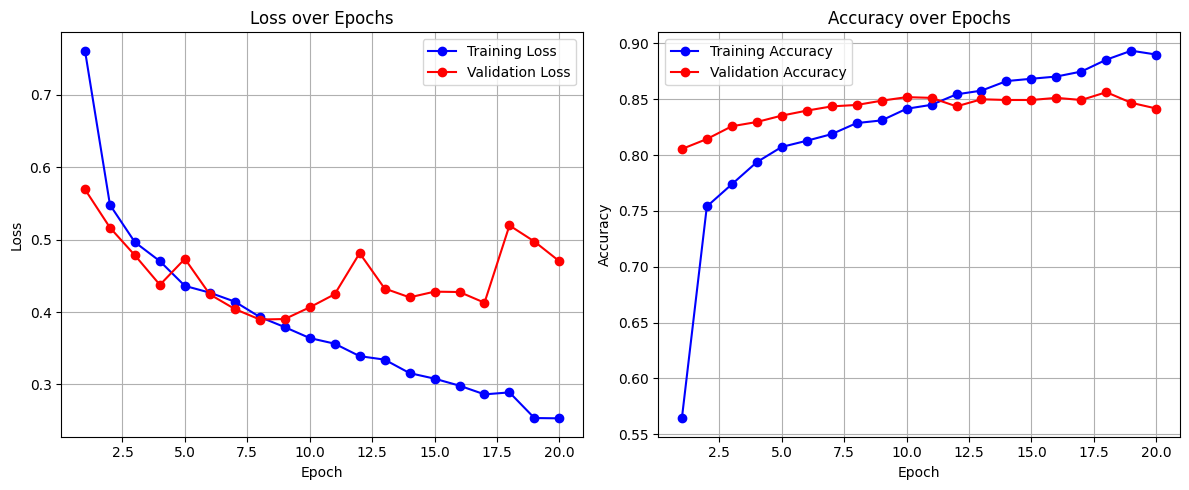

In [41]:
import matplotlib.pyplot as plt

# Extract history data
train_loss = history_50['train_loss']
val_loss = history_50['val_loss']
train_acc = history_50['train_acc']
val_acc = history_50['val_acc']
epochs = range(1, len(train_loss) + 1)

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


### Resnet152 + VisualBert

In [42]:
# Run training and evaluation
history_152 = train_model(model_152, resnet152, train_loader, val_loader, optimizer_152, loss_fn, device, epochs=20)

evaluate_model(model_152, resnet152, val_loader, device, loss_fn, "Validation")
evaluate_model(model_152, resnet152, test_loader, device, loss_fn, "Test")

Epoch 1 - Loss: 0.6350 - Accuracy: 0.66 | Val Loss: 0.6078 - Val Accuracy: 0.81
Epoch 2 - Loss: 0.5285 - Accuracy: 0.76 | Val Loss: 0.4706 - Val Accuracy: 0.82
Epoch 3 - Loss: 0.4852 - Accuracy: 0.78 | Val Loss: 0.4597 - Val Accuracy: 0.83
Epoch 4 - Loss: 0.4559 - Accuracy: 0.80 | Val Loss: 0.4494 - Val Accuracy: 0.83
Epoch 5 - Loss: 0.4448 - Accuracy: 0.81 | Val Loss: 0.4168 - Val Accuracy: 0.84
Epoch 6 - Loss: 0.4304 - Accuracy: 0.81 | Val Loss: 0.4087 - Val Accuracy: 0.84
Epoch 7 - Loss: 0.4057 - Accuracy: 0.83 | Val Loss: 0.4665 - Val Accuracy: 0.84
Epoch 8 - Loss: 0.3892 - Accuracy: 0.83 | Val Loss: 0.3963 - Val Accuracy: 0.84
Epoch 9 - Loss: 0.3888 - Accuracy: 0.84 | Val Loss: 0.4228 - Val Accuracy: 0.84
Epoch 10 - Loss: 0.3641 - Accuracy: 0.85 | Val Loss: 0.3809 - Val Accuracy: 0.85
Epoch 11 - Loss: 0.3666 - Accuracy: 0.85 | Val Loss: 0.4240 - Val Accuracy: 0.85
Epoch 12 - Loss: 0.3503 - Accuracy: 0.85 | Val Loss: 0.4142 - Val Accuracy: 0.84
Epoch 13 - Loss: 0.3332 - Accuracy: 0

0.4858915222187837

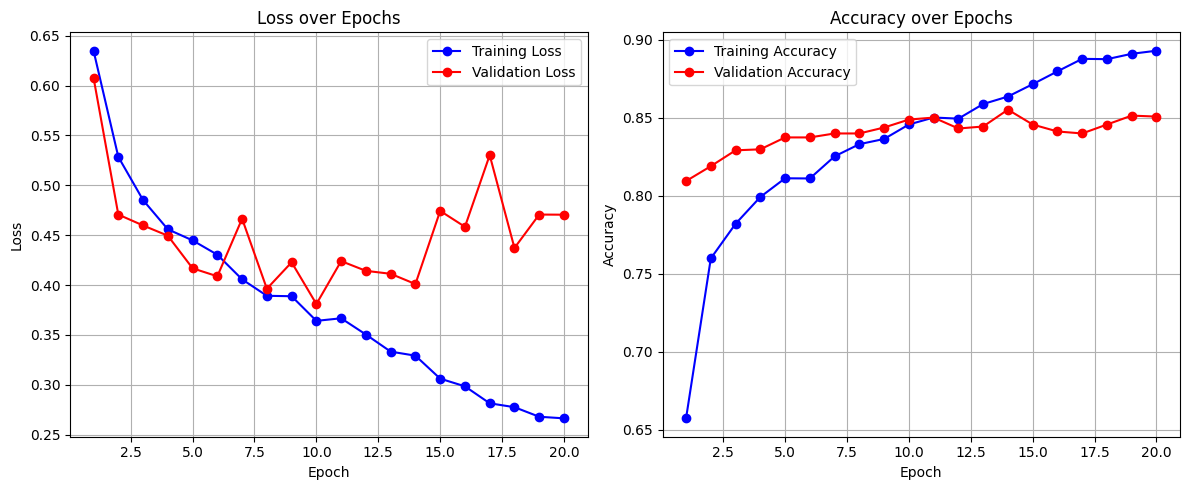

In [43]:
import matplotlib.pyplot as plt

# Extract history data
train_loss = history_152['train_loss']
val_loss = history_152['val_loss']
train_acc = history_152['train_acc']
val_acc = history_152['val_acc']
epochs = range(1, len(train_loss) + 1)

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


### DINOv2 (ViT) + VisualBert

In [50]:
# Run training and evaluation
history_dinov2 = train_model_DINOv2(
    model=model_Dino_v2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_DINOv2,
    loss_fn=loss_fn,
    device=device,
    epochs=20
)
evaluate_model_DINOv2(model_Dino_v2, dinov2, val_loader, device, loss_fn, split_name="Validation")
evaluate_model_DINOv2(model_Dino_v2, dinov2, test_loader, device, loss_fn, split_name="Test")



Epoch 1 - Loss: 0.7786 - Accuracy: 0.51 | Val Loss: 0.6212 - Val Accuracy: 0.76
Epoch 2 - Loss: 0.5701 - Accuracy: 0.72 | Val Loss: 0.4922 - Val Accuracy: 0.82
Epoch 3 - Loss: 0.4900 - Accuracy: 0.79 | Val Loss: 0.4347 - Val Accuracy: 0.82
Epoch 4 - Loss: 0.4513 - Accuracy: 0.81 | Val Loss: 0.4768 - Val Accuracy: 0.83
Epoch 5 - Loss: 0.4494 - Accuracy: 0.81 | Val Loss: 0.4472 - Val Accuracy: 0.84
Epoch 6 - Loss: 0.4074 - Accuracy: 0.82 | Val Loss: 0.3795 - Val Accuracy: 0.85
Epoch 7 - Loss: 0.3913 - Accuracy: 0.83 | Val Loss: 0.4235 - Val Accuracy: 0.84
Epoch 8 - Loss: 0.3758 - Accuracy: 0.83 | Val Loss: 0.4057 - Val Accuracy: 0.85
Epoch 9 - Loss: 0.3701 - Accuracy: 0.84 | Val Loss: 0.4264 - Val Accuracy: 0.85
Epoch 10 - Loss: 0.3612 - Accuracy: 0.85 | Val Loss: 0.3930 - Val Accuracy: 0.85
Epoch 11 - Loss: 0.3481 - Accuracy: 0.85 | Val Loss: 0.4650 - Val Accuracy: 0.85
Epoch 12 - Loss: 0.3293 - Accuracy: 0.86 | Val Loss: 0.4026 - Val Accuracy: 0.85
Epoch 13 - Loss: 0.3142 - Accuracy: 0

0.521236297984918

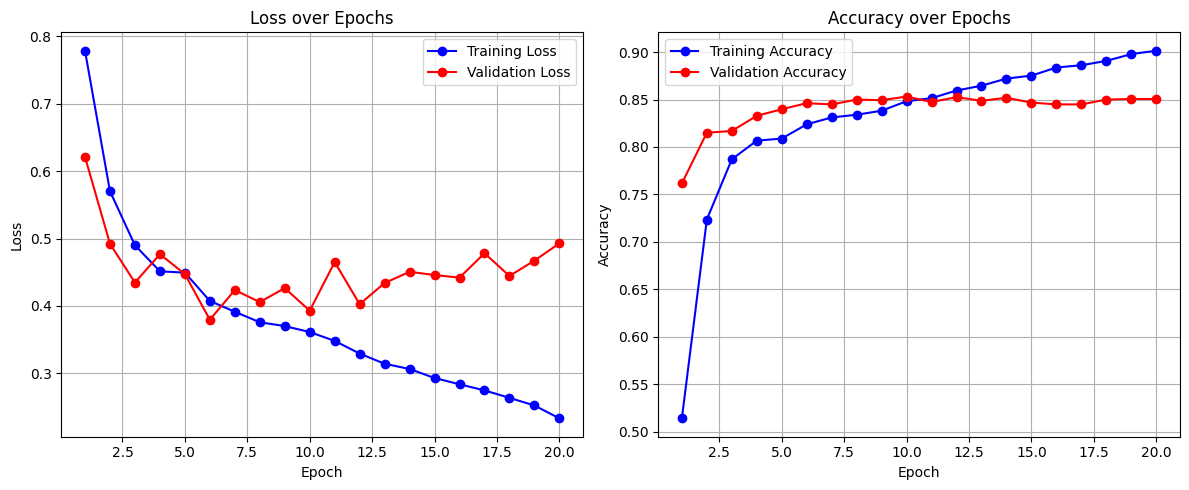

In [51]:
import matplotlib.pyplot as plt

# Extract history data
train_loss = history_dinov2['train_loss']
val_loss = history_dinov2['val_loss']
train_acc = history_dinov2['train_acc']
val_acc = history_dinov2['val_acc']
epochs = range(1, len(train_loss) + 1)

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


## Stage One Results and Summary

### Objective
The goal was to build a multimodal classifier using **VisualBERT** to detect whether crisis-related tweets are *Informative* or *Uninformative* based on both the tweet text and its associated image, and experiment with multiple visual encoders, namely, **ResNet-50**, **ResNet-152**, and **DINOv2**.

---

### Model Performance

#### ResNet-50 + VisualBERT
- Achieved a validation accuracy of **85%** at the best epoch.
- Validation loss stabilized around **0.47**.
- Test accuracy was consistent at **84%**.
- The model demonstrated strong precision and recall for the *Informative* class (Precision: 0.89, Recall: 0.88) and slightly lower performance on the *Uninformative* class (Precision: 0.75, Recall: 0.78).
  
#### ResNet-152 + VisualBERT
- Achieved the highest validation accuracy of **86%**.
- Validation loss was similar to ResNet-50 at approximately **0.47**.
- Test accuracy improved slightly to **86%**.
- Precision and recall for *Informative* tweets were high (Precision: 0.88, Recall: 0.90), and the *Uninformative* class also improved compared to ResNet-50 (Precision: 0.79, Recall: 0.76).

#### DINOv2 (ViT) + VisualBERT
- Validation accuracy reached **85%**, matching ResNet-152.
- Validation loss was a bit higher at **0.49**, and test loss was also higher (**0.52**).
- Precision and recall for *Informative* tweets remained strong (Precision: 0.87, Recall: 0.93).
- The *Uninformative* class showed the highest precision among all models (0.83) but had a lower recall (0.71), indicating more missed *Uninformative* samples.

---

### 🔍 Summary Table

| Visual Encoder  | Best Val Accuracy | Val Loss | Test Accuracy | Test Loss | Precision (Informative) | Recall (Informative) | Precision (Uninformative) | Recall (Uninformative) |
|-----------------|-------------------|----------|---------------|-----------|------------------------|---------------------|---------------------------|-----------------------|
| ResNet-50       | 0.85              | 0.47     | 0.84          | 0.48      | 0.89                   | 0.88                | 0.75                      | 0.78                  |
| ResNet-152      | 0.86              | 0.47     | 0.86          | 0.49      | 0.88                   | 0.90                | 0.79                      | 0.76                  |
| DINOv2 (ViT)    | 0.85              | 0.49     | 0.86          | 0.52      | 0.87                   | 0.93                | 0.83                      | 0.71                  |

---







# Stage 2: Humanitarian Classification (crisismmd2hum)

After determining whether a sample is informative in Stage 1, we now perform a **second classification step** to identify whether the image contains **humanitarian content** — i.e., people affected by the disaster.


In [ ]:
# Load the Humanitarian Dataset
from datasets import load_dataset

dataset_hum = load_dataset("xiaoxl/crisismmd2hum")
print(dataset_hum)

In [54]:
# Inspect Columns and Example
print("Columns:", dataset_hum["train"].column_names)
print("Train Example:", dataset_hum["train"][0])
print("Dev Example:", dataset_hum["dev"][0])

Columns: ['event_name', 'tweet_id', 'image_id', 'tweet_text', 'image', 'label', 'label_text', 'label_image', 'label_text_image', 'image_path']
Train Example: {'event_name': 'california_wildfires', 'tweet_id': 917793137925459968, 'image_id': '917793137925459968_0', 'tweet_text': 'RT @KAKEnews: California wildfires destroy more than 50 structures: https://t.co/IkSrNpmT83 #KAKEnews https://t.co/8risKwbBqr', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x346 at 0x7920E418ADD0>, 'label': 'infrastructure_and_utility_damage', 'label_text': 'infrastructure_and_utility_damage', 'label_image': 'infrastructure_and_utility_damage', 'label_text_image': 'Positive', 'image_path': 'data_image/california_wildfires/10_10_2017/917793137925459968_0.jpg'}
Dev Example: {'event_name': 'california_wildfires', 'tweet_id': 920329866901381123, 'image_id': '920329866901381123_0', 'tweet_text': 'Family Miraculously Finds Dog They Lost When Escaping California Wildfires https://t.co/4GP0jXda74 

## Tokenizer Initialization & Label Mapping

This cell prepares the text processing and label encoding needed for the humanitarian classification task.

#### Tokenizer Setup
- Loads the **BERT base uncased** tokenizer using `BertTokenizerFast`.
- This tokenizer converts tweet text into token IDs that align with the pre-trained VisualBERT model vocabulary.

#### Label Encoding
- Extracts the set of unique label names from the training set of the `crisismmd2hum` dataset.



In [55]:
# Tokenizer & Label Mapping
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
label_list = sorted(set(example["label"] for example in dataset_hum["train"]))
label2id_hum = {label: idx for idx, label in enumerate(label_list)}
id2label_hum = {idx: label for label, idx in label2id_hum.items()}
print("Label mapping:", label2id_hum)

Label mapping: {'affected_individuals': 0, 'infrastructure_and_utility_damage': 1, 'not_humanitarian': 2, 'other_relevant_information': 3, 'rescue_volunteering_or_donation_effort': 4}


##  Humanitarian Dataset Prep

To prepare the `crisismmd2hum` dataset for training with PyTorch and BERT, we apply a custom preprocessing function and set the appropriate data format.

#### `preprocess_hum` Function
This function processes each example in the dataset by:
- **Tokenizing the text** (`tweet_text`) using the BERT tokenizer.
  - Applies padding and truncation to a fixed length of 128 tokens.
- **Converting labels** from strings (e.g., `"humanitarian"`) to integers using the `label2id_hum` mapping.
- Adds new fields to each example:
  - `input_ids`
  - `attention_mask`
  - `label` (as an integer)

#### Apply and Format
- The `.map(preprocess_hum)` call applies the function to the entire dataset efficiently.
- The `.set_format(...)` method ensures that the returned dataset is in **PyTorch tensor format**, with only the relevant fields:
  - `input_ids`, `attention_mask`, and `label`.

This ensures the data is ready to be wrapped in a `DataLoader` for model training.


In [56]:
# Preprocessing Function and Set Format
def preprocess_hum(example):
    encoding = tokenizer(
        example["tweet_text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )
    example["input_ids"] = encoding["input_ids"]
    example["attention_mask"] = encoding["attention_mask"]
    example["label"] = label2id_hum[example["label"]]
    return example

dataset_hum = dataset_hum.map(preprocess_hum)
dataset_hum.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/6126 [00:00<?, ? examples/s]

Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Map:   0%|          | 0/998 [00:00<?, ? examples/s]

Map:   0%|          | 0/955 [00:00<?, ? examples/s]

## Custom Dataset: `CrisisHumanitarianDataset`

This custom PyTorch `Dataset` class wraps the preprocessed humanitarian dataset and includes logic to handle missing or null images gracefully. Moreover, combines images and texts.



In [57]:
# Humanitarian Dataset Class (handles missing images)
from torch.utils.data import Dataset
from PIL import Image
import requests
from io import BytesIO

class CrisisHumanitarianDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        if "image" not in item or item["image"] is None:
            image = Image.new("RGB", (224, 224))  # blank fallback image
        else:
            image = item["image"].convert("RGB")

        if self.transform:
            image = self.transform(image)

        return {
            "input_ids": item["input_ids"],
            "attention_mask": item["attention_mask"],
            "pixel_values": image,
            "label": item["label"]
        }

In [58]:
# Define Transforms and Create Dataset Splits
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset_hum = CrisisHumanitarianDataset(dataset_hum["train"], transform=image_transform)
val_dataset_hum = CrisisHumanitarianDataset(dataset_hum["dev"], transform=image_transform)
test_dataset_hum = CrisisHumanitarianDataset(dataset_hum["test"], transform=image_transform)

In [59]:
# Define Collate Function
def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.stack([item["label"] for item in batch])
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "pixel_values": pixel_values,
        "label": labels
    }

In [60]:
# Create DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_loader_hum = DataLoader(train_dataset_hum, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=WORKERS)
val_loader_hum = DataLoader(val_dataset_hum, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=WORKERS)
test_loader_hum = DataLoader(test_dataset_hum, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=WORKERS)

## VisualBERT Humanitarian Classifier

This class defines a multimodal neural network for classifying whether crisis-related tweets contain **humanitarian content**. It leverages **VisualBERT** to combine textual and visual inputs.

#### Architecture
- **Backbone**: Uses a pre-trained `VisualBertModel` (`uclanlp/visualbert-vqa-coco-pre`) as the base encoder for joint text and image features.
- **Classifier Head**:
  - A fully connected layer reduces the pooled output size from 768 to 256.
  - Followed by a ReLU activation and dropout to prevent overfitting.
  - A final linear layer maps to the number of humanitarian label classes (e.g., `2`).

#### Forward Pass
- Accepts:
  - `input_ids`: token IDs from the BERT tokenizer.
  - `attention_mask`: attention mask for text tokens.
  - `visual_embeds`: image features extracted from a CNN (e.g., ResNet).
- Constructs a **visual attention mask** of ones (same shape as `visual_embeds`) to signal the model to attend to image features.
- Feeds the multimodal input into VisualBERT and applies the classifier head to the pooled output.

This model enables the identification of humanitarian-related content using combined visual and textual signals — ideal for humanitarian response use cases.


In [69]:
# Define VisualBERT Humanitarian Classifier
import torch
import torch.nn as nn
from transformers import VisualBertModel

class VisualBERTHumanitarianClassifier(nn.Module):
    def __init__(self, hidden_size=768, num_labels=len(label2id_hum)):
        super(VisualBERTHumanitarianClassifier, self).__init__()
        self.visualbert = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, visual_embeds):
        batch_size = input_ids.size(0)
        num_visual_tokens = visual_embeds.size(1)

        # Create visual attention mask of shape [batch_size, num_visual_tokens]
        visual_attention_mask = torch.ones((batch_size, num_visual_tokens), dtype=torch.long).to(input_ids.device)

        outputs = self.visualbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            visual_embeds=visual_embeds,
            visual_attention_mask=visual_attention_mask
        )
        return self.classifier(outputs.pooler_output)

## ResNet Feature Extractor and Weighted Loss for Humanitarian Classification

This section sets up the **image encoder** and computes **class weights** to handle class imbalance in the humanitarian classification task.

#### 🖼️ ResNet-152 Feature Extractor
- Loads a pre-trained **ResNet-152** model with `IMAGENET1K_V1` weights.
- Replaces the final classification layer (`fc`) with an identity layer (`nn.Identity()`), turning ResNet into a **pure feature extractor**.
- The model is set to **evaluation mode** with `resnet.eval()` to disable training-time behavior like dropout and batch norm updates.

#### ⚖️ Handling Class Imbalance
- Aggregates all labels from `train_loader_hum` to count class occurrences.
- Uses `Counter` to tally each class and calculate the **inverse frequency** for each:
  - Formula: `weight = total / (num_classes * count_per_class)`
- Converts the list of weights into a tensor and moves it to the correct computation device.

#### 🎯 Weighted Loss Function
- Applies `nn.CrossEntropyLoss(weight=...)` using the computed class weights.
- This gives more importance to underrepresented classes (e.g., "humanitarian" or "not_humanitarian") during training, which helps balance performance across classes.

This combination ensures the model receives both strong visual features and fair loss weighting to improve classification of underrepresented humanitarian samples.


In [ ]:
# Load ResNet Feature Extractor
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet152 as ResNet152
resnet_hum = ResNet152(weights=ResNet152_Weights.IMAGENET1K_V1)
resnet_hum.fc = nn.Identity()
resnet_hum.eval()

In [71]:
# Compute class weights from the training dataset
import torch
import numpy as np
from collections import Counter

# Assumes train_loader_hum is already defined and yields batches with 'label' tensors
all_labels = []

for batch in train_loader_hum:
    all_labels.extend(batch['label'].tolist())

label_counts = Counter(all_labels)
num_classes = len(label_counts)
total = sum(label_counts.values())

# Compute weight for each class: inverse frequency
class_weights = [total / (num_classes * label_counts[i]) for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use weighted loss
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

## Training: `train_humanitarian_model`

This function trains the `VisualBERTHumanitarianClassifier` using multimodal input (text and image features) and tracks performance across epochs.


#### Output
Prints epoch-wise metrics and returns `history` containing:
- `train_loss`, `val_loss`
- `train_acc`, `val_acc`

This training loop ensures the model learns effectively while monitoring overfitting and guiding learning rate adjustment with the scheduler.


In [72]:
# Training Function
def train_humanitarian_model(model, resnet, train_loader, val_loader, optimizer, loss_fn, scheduler, device, epochs=5):
    model.to(device)
    resnet.to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            with torch.no_grad():
                visual_embeds = resnet(pixel_values)
                if visual_embeds.dim() == 4:
                    visual_embeds = visual_embeds.squeeze(-1).squeeze(-1)
                visual_embeds = visual_embeds.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, visual_embeds)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        running_loss /= len(train_loader)
        scheduler.step(running_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["label"].to(device)

                visual_embeds = resnet(pixel_values)
                if visual_embeds.dim() == 4:
                    visual_embeds = visual_embeds.squeeze(-1).squeeze(-1)
                visual_embeds = visual_embeds.unsqueeze(1)

                outputs = model(input_ids, attention_mask, visual_embeds)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss /= len(val_loader)

        # Save history
        history['train_loss'].append(running_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


## Evaluation: `evaluate_humanitarian_model`

This function evaluates the trained humanitarian classifier on a given dataset split (e.g., validation or test) and prints a detailed classification report.

#### 📈 Performance Reporting
- Uses `sklearn.metrics.classification_report` to print:
  - Precision, recall, and F1-score for each class (`humanitarian`, `not_humanitarian`).




In [73]:
# Evaluation Function
def evaluate_humanitarian_model(model, resnet, dataloader, device):
    model.eval()
    resnet.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            visual_embeds = resnet(pixel_values).unsqueeze(1)  # ← FIX HERE
            outputs = model(input_ids, attention_mask, visual_embeds)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_preds, target_names=list(label2id_hum.keys())))

## Training and Evaluation: Humanitarian Classification Model

In [74]:
# Train and Evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_hum = VisualBERTHumanitarianClassifier()
optimizer = torch.optim.AdamW(model_hum.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# loss_fn is defined earlier using weighted class strategy
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=PATIENCE, factor=FACTOR)

history_hmn_nhmn = train_humanitarian_model(
    model=model_hum,
    resnet=resnet_hum,
    train_loader=train_loader_hum,
    val_loader=val_loader_hum,
    optimizer=optimizer,
    loss_fn=loss_fn,
    scheduler=scheduler,
    device=device,
    epochs=20
)

evaluate_humanitarian_model(model_hum, resnet, test_loader_hum, device)

Epoch 1, Train Loss: 1.5071, Train Acc: 0.3346, Val Loss: 1.2049, Val Acc: 0.6844
Epoch 2, Train Loss: 0.9796, Train Acc: 0.7186, Val Loss: 0.8112, Val Acc: 0.7194
Epoch 3, Train Loss: 0.5925, Train Acc: 0.8168, Val Loss: 0.6770, Val Acc: 0.7715
Epoch 4, Train Loss: 0.4498, Train Acc: 0.8528, Val Loss: 0.7746, Val Acc: 0.7745
Epoch 5, Train Loss: 0.3646, Train Acc: 0.8733, Val Loss: 0.7681, Val Acc: 0.7816
Epoch 6, Train Loss: 0.2673, Train Acc: 0.9004, Val Loss: 0.8000, Val Acc: 0.7936
Epoch 7, Train Loss: 0.2182, Train Acc: 0.9262, Val Loss: 0.8098, Val Acc: 0.7876
Epoch 8, Train Loss: 0.1612, Train Acc: 0.9434, Val Loss: 0.9137, Val Acc: 0.7685
Epoch 9, Train Loss: 0.1237, Train Acc: 0.9546, Val Loss: 0.8979, Val Acc: 0.7836
Epoch 10, Train Loss: 0.1007, Train Acc: 0.9620, Val Loss: 0.9748, Val Acc: 0.7946
Epoch 11, Train Loss: 0.0871, Train Acc: 0.9690, Val Loss: 0.9899, Val Acc: 0.7856
Epoch 12, Train Loss: 0.0863, Train Acc: 0.9691, Val Loss: 1.0086, Val Acc: 0.7906
Epoch 13, Tra

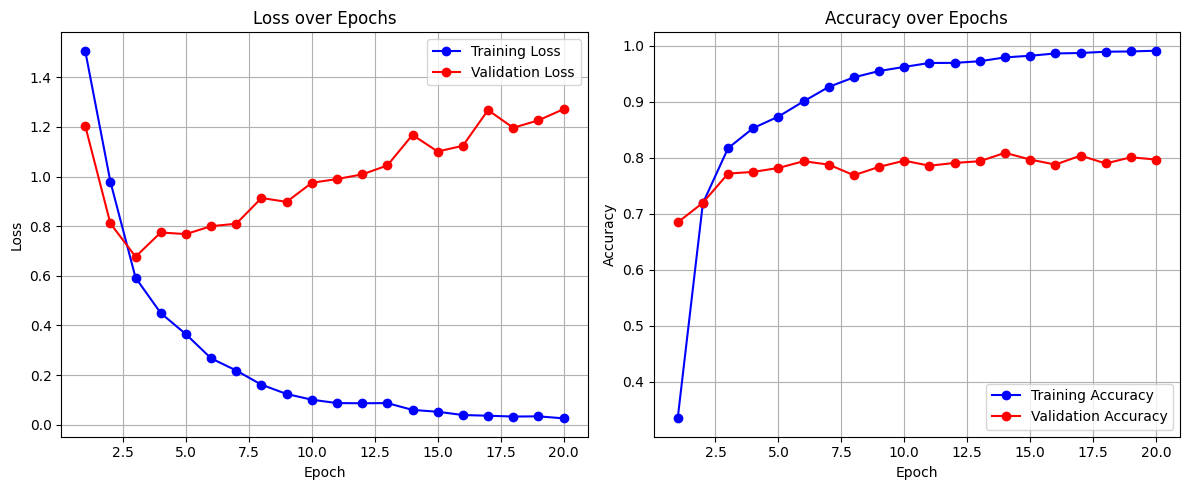

In [75]:
import matplotlib.pyplot as plt

# Extract history data
train_loss = history_hmn_nhmn['train_loss']
val_loss = history_hmn_nhmn['val_loss']
train_acc = history_hmn_nhmn['train_acc']
val_acc = history_hmn_nhmn['val_acc']
epochs = range(1, len(train_loss) + 1)

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


## Results and Summary – Humanitarian Classification

### Objective
The goal of this second stage was to build a multimodal classifier using **VisualBERT** and **ResNet-152** to determine whether crisis-related social media posts contain **humanitarian content** — i.e., content involving people affected by the disaster.

The task uses the `crisismmd2hum` dataset and follows up on the informativeness filter. Only samples deemed informative in Stage 1 are passed to this classifier.

---

### 📈 Training Summary

The model was trained for 20 epochs using a class-weighted loss to address class imbalance, with the ResNet-152 feature extractor frozen in evaluation mode. Training accuracy improved steadily from 33% in the first epoch to over 99% by the final epoch, showing rapid convergence.

Validation accuracy increased quickly during the first 6–7 epochs, reaching approximately **79%** and plateauing thereafter. Despite continuing gains in training accuracy, validation accuracy showed slight fluctuations and signs of overfitting starting from epoch 8, with validation loss increasing after epoch 6.

| Epoch | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy |
|-------|------------|----------------|-----------------|---------------------|
| 1     | 1.5071     | 33.46%         | 1.2049          | 68.44%              |
| 2     | 0.9796     | 71.86%         | 0.8112          | 71.94%              |
| 3     | 0.5925     | 81.68%         | 0.6770          | 77.15%              |
| 4     | 0.4498     | 85.28%         | 0.7746          | 77.45%              |
| 5     | 0.3646     | 87.33%         | 0.7681          | 78.16%              |
| 6     | 0.2673     | 90.04%         | 0.8000          | 79.36%              |
| 7     | 0.2182     | 92.62%         | 0.8098          | 78.76%              |
| 8     | 0.1612     | 94.34%         | 0.9137          | 76.85%              |
| 9     | 0.1237     | 95.46%         | 0.8979          | 78.36%              |
| 10    | 0.1007     | 96.20%         | 0.9748          | 79.46%              |
| …     | …          | …              | …               | …                   |
| 20    | 0.0256     | 99.09%         | 1.2715          | 79.66%              |

---

### 📊 Evaluation Metrics on Test Set

The model achieved an overall accuracy of **79%** on 955 test samples, with the following class-wise precision, recall, and F1-scores:

| Class                                  | Precision | Recall | F1-Score | Support |
|----------------------------------------|-----------|--------|----------|---------|
| Affected Individuals                   | 0.50      | 0.56   | 0.53     | 9       |
| Infrastructure and Utility Damage     | 0.71      | 0.73   | 0.72     | 81      |
| Not Humanitarian                      | 0.86      | 0.82   | 0.84     | 504     |
| Other Relevant Information             | 0.76      | 0.72   | 0.74     | 235     |
| Rescue, Volunteering, or Donation Effort | 0.71   | 0.87   | 0.79     | 126     |

- **Macro average:** Precision 0.71, Recall 0.74, F1-score 0.72
- **Weighted average:** Precision 0.80, Recall 0.79, F1-score 0.80

---

### 🔎 Insights

- The model effectively distinguishes **humanitarian** from **non-humanitarian** content within crisis-related informative posts, with the highest performance on the majority classes like *Not Humanitarian* and *Other Relevant Information*.
- Performance on the *Affected Individuals* class is relatively low, likely due to the small number of samples and the inherent difficulty of the class.
- Signs of overfitting in later epochs suggest potential for further tuning, such as early stopping or stronger regularization.
- The use of class-weighted loss helped improve recall on minority classes like *Rescue and Donation Efforts*.

---






